In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)


In [2]:
import sys
!{sys.executable} -m pip install openpyxl


   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]



In [3]:

data_path = "./AlibabaStock2021-2023.xlsx"

df = pd.read_excel(data_path)
print(df.head())
print(df.dtypes)


          日期         开盘价         最高价         最低价         收盘价       成交量
0 2021-01-04  226.500000  230.380005  225.039993  227.850006  24897900
1 2021-01-05  229.050003  240.759995  228.119995  240.399994  35823800
2 2021-01-06  234.949997  238.300003  225.860001  227.610001  37146100
3 2021-01-07  229.309998  229.949997  220.089996  226.899994  49361800
4 2021-01-08  227.880005  238.600006  226.682999  236.190002  34884900
日期     datetime64[ns]
开盘价           float64
最高价           float64
最低价           float64
收盘价           float64
成交量             int64
dtype: object


数据条数： 588


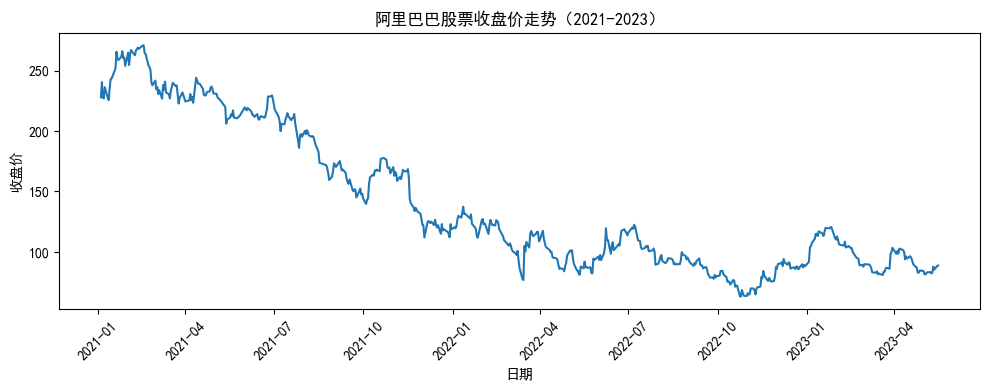

In [4]:

# 确保按日期升序排序
df = df.sort_values("日期").reset_index(drop=True)
print("数据条数：", len(df))

# 简单画一下收盘价走势
plt.figure(figsize=(10, 4))
plt.plot(df["日期"], df["收盘价"])
plt.title("阿里巴巴股票收盘价走势（2021-2023）")
plt.xlabel("日期")
plt.ylabel("收盘价")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:

feature_cols = ["开盘价", "最高价", "最低价", "收盘价", "成交量"]
data = df[feature_cols].values.astype("float32")

# 按时间顺序划分为 70% 训练、15% 验证、15% 测试（先在时间步上划分，再构造序列）
n_total = len(data)
train_end = int(n_total * 0.7)

train_data = data[:train_end]

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
data_scaled = (data - mean) / std

# 目标为收盘价
target = df["收盘价"].values.astype("float32")
target_mean = target[:train_end].mean()
target_std = target[:train_end].std()
target_scaled = (target - target_mean) / target_std

print("标准化完成。第一条特征：", data_scaled[0])


标准化完成。第一条特征： [1.1486319  1.1764941  1.1744975  1.1814988  0.08997327]


In [6]:

def create_sequences(features, target, window_size=30, horizon=2):
    X, y = [], []
    for i in range(len(features) - window_size - horizon + 1):
        X.append(features[i : i + window_size])
        # 目标是窗口之后 horizon 天的值
        y.append(target[i + window_size + horizon - 1])
    return np.array(X, dtype="float32"), np.array(y, dtype="float32")


window_size = 30
horizon = 2

X_all, y_all = create_sequences(data_scaled, target_scaled,
                                window_size=window_size,
                                horizon=horizon)

print("X_all 形状:", X_all.shape)  # (样本数, 30, 5)
print("y_all 形状:", y_all.shape)


X_all 形状: (557, 30, 5)
y_all 形状: (557,)


In [7]:

n_samples = X_all.shape[0]
train_end = int(n_samples * 0.7)
val_end = int(n_samples * 0.85)

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

print("训练集：", X_train.shape, y_train.shape)
print("验证集：", X_val.shape, y_val.shape)
print("测试集：", X_test.shape, y_test.shape)


训练集： (389, 30, 5) (389,)
验证集： (84, 30, 5) (84,)
测试集： (84, 30, 5) (84,)


In [8]:

model = keras.models.Sequential([
    layers.Input(shape=(window_size, X_all.shape[-1])),
    layers.GRU(64, return_sequences=True),
    layers.GRU(32),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 30, 64)              │          13,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,585 (92.13 KB)

 Trainable params: 23,585 (92.13 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1215 - mae: 0.2708 - val_loss: 0.0233 - val_mae: 0.1061
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0306 - mae: 0.1411 - val_loss: 0.0267 - val_mae: 0.1340
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0211 - mae: 0.1151 - val_loss: 0.0228 - val_mae: 0.1199
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0196 - mae: 0.1090 - val_loss: 0.0196 - val_mae: 0.1094
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0195 - mae: 0.1094 - val_loss: 0.0237 - val_mae: 0.1248
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0180 - mae: 0.1036 - val_loss: 0.0231 - val_mae: 0.1246
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0183 - mae: 0.1053 - val_loss: 0.0199 - val_mae: 0.1132
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0187 - mae: 0.1068 - val_loss: 0.0174 - val_mae: 0.1038
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.01

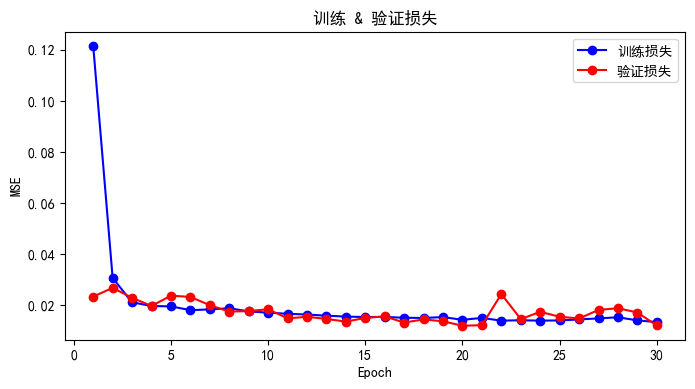

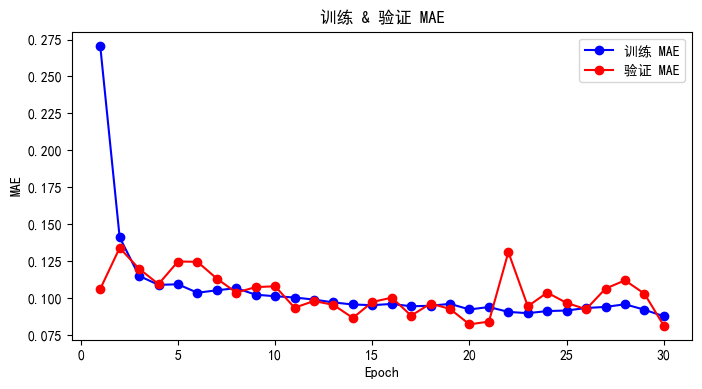

In [10]:

# 绘制训练 & 验证损失/MAE 曲线
history_dict = history.history
epochs = range(1, len(history_dict["loss"]) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, history_dict["loss"], "bo-", label="训练损失")
plt.plot(epochs, history_dict["val_loss"], "ro-", label="验证损失")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("训练 & 验证损失")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, history_dict["mae"], "bo-", label="训练 MAE")
plt.plot(epochs, history_dict["val_mae"], "ro-", label="验证 MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("训练 & 验证 MAE")
plt.legend()
plt.show()


In [11]:

test_mse, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"测试集 MSE（标准化后）: {test_mse:.4f}")
print(f"测试集 MAE（标准化后）: {test_mae:.4f}")

# 预测并反标准化到真实价格
y_pred_scaled = model.predict(X_test)
y_pred = y_pred_scaled.squeeze() * target_std + target_mean
y_true = y_test * target_std + target_mean

# 打印部分样本的真实值与预测值
for i in range(10):
    print(f"样本 {i}: 真实收盘价 = {y_true[i]:.2f}, 预测收盘价 = {y_pred[i]:.2f}")


测试集 MSE（标准化后）: 0.0056
测试集 MAE（标准化后）: 0.0566
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
样本 0: 真实收盘价 = 115.19, 预测收盘价 = 109.10
样本 1: 真实收盘价 = 113.22, 预测收盘价 = 110.61
样本 2: 真实收盘价 = 116.58, 预测收盘价 = 110.86
样本 3: 真实收盘价 = 119.86, 预测收盘价 = 110.45
样本 4: 真实收盘价 = 119.53, 预测收盘价 = 110.61
样本 5: 真实收盘价 = 119.44, 预测收盘价 = 112.17
样本 6: 真实收盘价 = 120.25, 预测收盘价 = 113.23
样本 7: 真实收盘价 = 120.57, 预测收盘价 = 113.16
样本 8: 真实收盘价 = 118.38, 预测收盘价 = 113.69
样本 9: 真实收盘价 = 111.20, 预测收盘价 = 114.41


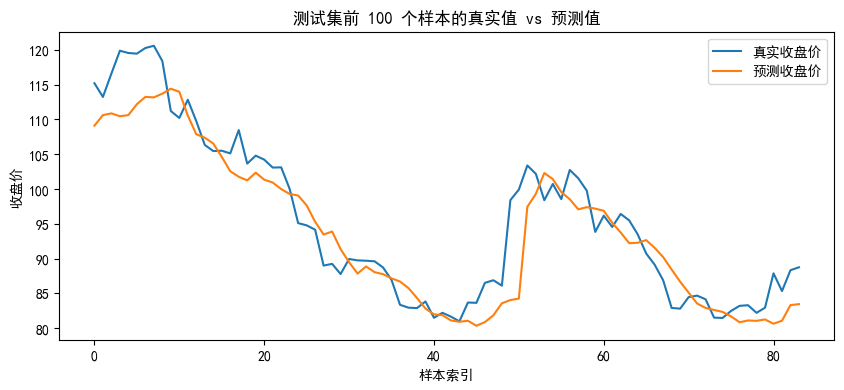

In [12]:

# 画出一段时间内的真实值 vs 预测值曲线
plt.figure(figsize=(10, 4))
plt.plot(y_true[:100], label="真实收盘价")
plt.plot(y_pred[:100], label="预测收盘价")
plt.title("测试集前 100 个样本的真实值 vs 预测值")
plt.xlabel("样本索引")
plt.ylabel("收盘价")
plt.legend()
plt.show()
